# Requirements


In [4]:
 #!pip install datasets
 #!pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu
!pip install 'torchmetrics[image]'

In [5]:
import torch
import random

# Set random seed for reproducibility
manualSeed = 999
# manualSeed = random.randint(1, 10000)  # Use this if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)  # Needed for reproducible results

# Check for CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Random Seed:  999
Using device: cuda:0


In [6]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pickle
import os
import kagglehub

In [7]:
# Set random seed for reproducibility
manualSeed = 999
# manualSeed = random.randint(1, 10000)  # Use this if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Check for CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
torch.use_deterministic_algorithms(False) # Needed for reproducible results

Random Seed:  999
Using device: cuda:0


In [8]:
# Root directory for dataset
root_dir="images/wiki"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 40

# Learning rate for optimizers
lrG = 0.0002
lrD = 0.0001
# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

celeba=False

100%|██████████| 1.33G/1.33G [00:06<00:00, 224MB/s]

Extracting files...


✅ Dataset downloaded to: /teamspace/studios/this_studio/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2


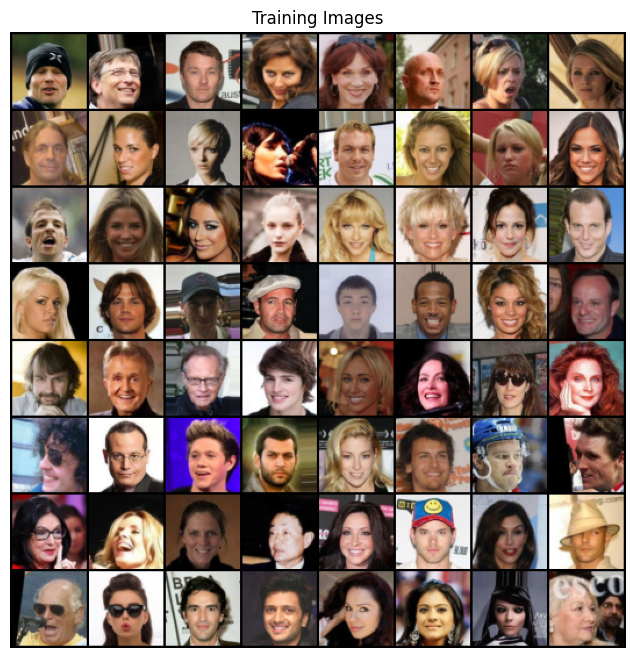

In [ ]:
# Download the CelebA dataset via KaggleHub
if celeba:
    path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
    print("✅ Dataset downloaded to:", path)

    # Define root_dir to where the image folder is
    root_dir = os.path.join(path, "img_align_celeba")

# Load dataset using ImageFolder
dataset = dset.ImageFolder(root=root_dir,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Choose device
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Visualize a batch of real images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(
    vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),
    (1, 2, 0)
))
plt.show()

In [10]:
print(f"Using device: {device}")
#print(f"netG is on: {next(netG.parameters()).device}")
#print(f"netD is on: {next(netD.parameters()).device}")

Using device: cuda:0


Weight Initialization

In [11]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Generator

In [12]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [13]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Discriminator

In [14]:
class WGANDiscriminator(nn.Module):
    def __init__(self, ngpu):
        super(WGANDiscriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input: (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            # Output: 1x1x1 (flattened below)
        )

    def forward(self, input):
        return self.main(input).view(-1)

In [15]:
# Create the Discriminator
netD = WGANDiscriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

WGANDiscriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


Loss Functions and Optimizers


In [16]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.RMSprop(netD.parameters(), lr=lrD)
optimizerG = torch.optim.RMSprop(netG.parameters(), lr=lrG)

## Computing Gradient Penalty

In [17]:
def compute_gradient_penalty(D, real_samples, fake_samples, device):
    # Ensure both inputs have the same batch size
    if real_samples.size(0) != fake_samples.size(0):
        raise ValueError(f"Batch size mismatch: real({real_samples.size(0)}), fake({fake_samples.size(0)})")

    batch_size = real_samples.size(0)

    # Sample epsilon from uniform distribution [0, 1]
    epsilon = torch.rand(batch_size, 1, 1, 1, device=device)

    # Interpolate between real and fake samples
    interpolates = (epsilon * real_samples + (1 - epsilon) * fake_samples).requires_grad_(True)

    # Discriminator output for interpolated images
    d_interpolates = D(interpolates)

    # For WGAN-GP: create gradient outputs filled with 1s
    grad_outputs = torch.ones_like(d_interpolates, device=device)

    # Compute gradients of D(interpolates) w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Flatten gradients per sample and compute L2 norm
    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)

    # Compute gradient penalty: (||grad||_2 - 1)^2
    penalty = ((gradient_norm - 1) ** 2).mean()
    return penalty



# Computing Fréchet inception distance

In [18]:
import torch
import torchvision.transforms as transforms
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.models import inception_v3
from torchvision.utils import save_image

# Ensure FID calculation happens in evaluation mode
fid_metric = FrechetInceptionDistance(feature=2048).to("cuda" if torch.cuda.is_available() else "cpu")

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /home/zeus/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 217MB/s]


In [19]:
def compute_fid(real_images, fake_images, fid_metric):
    """Computes FID between real and fake images."""
    
    real_images = (real_images * 255).byte()
    fake_images = (fake_images * 255).byte()
   
    # Update the metric with real and fake images
    fid_metric.update(real_images, real=True)
    fid_metric.update(fake_images, real=False)

    # Compute FID
    fid_score = fid_metric.compute()
    
    # Reset metric for next evaluation
    fid_metric.reset()
    
    return fid_score.item()


In [22]:

checkpoint_file = "checkpoints/wgan_checkpoint_epoch_5.pkl"  # Replace with latest checkpoint if needed

if os.path.exists(checkpoint_file):
    with open(checkpoint_file, "rb") as f:
        checkpoint = pickle.load(f)

    netG.load_state_dict(checkpoint['netG_state_dict'])
    netD.load_state_dict(checkpoint['netD_state_dict'])
    optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
    optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])

    start_epoch = checkpoint.get('epoch', 0) + 1
    G_losses = checkpoint.get('G_losses', [])
    D_losses = checkpoint.get('D_losses', [])
    FID_scores = checkpoint.get('FID_scores', [])
    iters = checkpoint.get('iters', 0)

    print(f"✅ Resumed training from epoch {start_epoch}")
else:
    print("🚀 No checkpoint found. Starting from scratch.")
    start_epoch = 0
    G_losses, D_losses, FID_scores = [], [], []
    iters = 0

🚀 No checkpoint found. Starting from scratch.


In [24]:
print(f"Using device: {device}")
print(f"netG is on: {next(netG.parameters()).device}")
print(f"netD is on: {next(netD.parameters()).device}")

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
FID_scores = []
iters = 0
iter_counter = 0
n_critic = 5  # Update the Discriminator 5 times for every 1 Generator update

def show_generated_images(img_tensor, title=None):
    npimg = img_tensor.numpy()
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    if title:
        plt.title(title)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloader, 0):

        ############################
        # (1) Update D network
        ############################
        for _ in range(n_critic):
            netD.zero_grad()

            # Get real images and infer actual batch size
            real_images = images.to(device)
            curr_batch_size = real_images.size(0)

            # Generate fake images
            noise = torch.randn(curr_batch_size, nz, 1, 1, device=device)
            fake_images = netG(noise).detach()

            # Get discriminator outputs
            output_real = netD(real_images)
            output_fake = netD(fake_images)

            # Compute gradient penalty
            lambda_gp = 10
            gp = compute_gradient_penalty(netD, real_images.data, fake_images.data, device)

            # Final discriminator loss
            D_loss = -torch.mean(output_real) + torch.mean(output_fake) + lambda_gp * gp

            try:
                D_loss.backward()
            except RuntimeError as e:
                print("Backward Error:", e)
            optimizerD.step()

        ############################
        # (2) Update G network
        ############################
        netG.zero_grad()
        noise = torch.randn(curr_batch_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        output_fake = netD(fake_images)
        G_loss = -torch.mean(output_fake)
        G_loss.backward()
        optimizerG.step()

        # Print losses occasionally
        if i % 50 == 0:
            print(f"[{epoch}/{num_epochs}][{i}/{len(dataloader)}] "
                  f"Loss_D: {D_loss.item():.4f} Loss_G: {G_loss.item():.4f}")

        # Save losses
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

        # Compute FID score every epoch at the first batch
        if i == 0:
            fid_metric = fid_metric.to(device)
            with torch.no_grad():
                noise = torch.randn(100, nz, 1, 1, device=device)
                fake_images = netG(noise)
                real_images, _ = next(iter(dataloader))
                real_images = real_images[:100].to(device)
                fid_score = compute_fid(real_images, fake_images, fid_metric)
                fid_metric.reset()
                FID_scores.append(fid_score)
                print(f"FID Score at Epoch {epoch}: {fid_score:.4f}")

        # Save generated images from fixed noise
        if i == 0:
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
                img_grid = vutils.make_grid(fake, padding=2, normalize=True)
                img_list.append(img_grid)
                # show_generated_images(img_grid, f"Generated Images at Epoch {epoch}")

        iters += 1
        iter_counter += 1
    checkpoint_path = "checkpoints/"
    os.makedirs(checkpoint_path, exist_ok=True)

    if (epoch + 1) % 50 == 0:
        save_data = {
        'epoch': epoch,
        'netG_state_dict': netG.state_dict(),
        'netD_state_dict': netD.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict(),
        'G_losses': G_losses,
        'D_losses': D_losses,
        'FID_scores': FID_scores,
        'iters': iters
    }
        with open(f"{checkpoint_path}/wgan_checkpoint_epoch_{epoch+1}.pkl", "wb") as f:
            pickle.dump(save_data, f)
        print(f"Checkpoint saved at epoch {epoch+1}")



Using device: cuda:0
netG is on: cuda:0
netD is on: cuda:0
Starting Training Loop...
[0/40][0/1583] Loss_D: -15.2228 Loss_G: 21.5233
FID Score at Epoch 0: 255.8553
[0/40][50/1583] Loss_D: -12.9790 Loss_G: -22.1350
[0/40][100/1583] Loss_D: -13.0538 Loss_G: 5.6286
[0/40][150/1583] Loss_D: -10.4605 Loss_G: -4.7894
[0/40][200/1583] Loss_D: -11.7684 Loss_G: -13.5239
[0/40][250/1583] Loss_D: -11.6086 Loss_G: 1.4814
[0/40][300/1583] Loss_D: -12.6021 Loss_G: 35.9905
[0/40][350/1583] Loss_D: -11.7673 Loss_G: -7.4976
[0/40][400/1583] Loss_D: -10.3304 Loss_G: 8.3794
[0/40][450/1583] Loss_D: -10.6126 Loss_G: 25.3754
[0/40][500/1583] Loss_D: -10.4875 Loss_G: 25.4274
[0/40][550/1583] Loss_D: -9.4075 Loss_G: 27.9715
[0/40][600/1583] Loss_D: -8.9377 Loss_G: 16.5685
[0/40][650/1583] Loss_D: -8.9713 Loss_G: -0.5524
[0/40][700/1583] Loss_D: -8.3256 Loss_G: 4.8099
[0/40][750/1583] Loss_D: -9.3946 Loss_G: 1.9877
[0/40][800/1583] Loss_D: -10.1444 Loss_G: 30.7646
[0/40][850/1583] Loss_D: -6.7136 Loss_G: 25.0

KeyboardInterrupt: 

# Evolution of the Frechet Distance

In [25]:
print(FID_scores)

[255.85531616210938, 191.57415771484375, 162.95822143554688, 152.7454376220703, 142.2100372314453, 143.27154541015625]


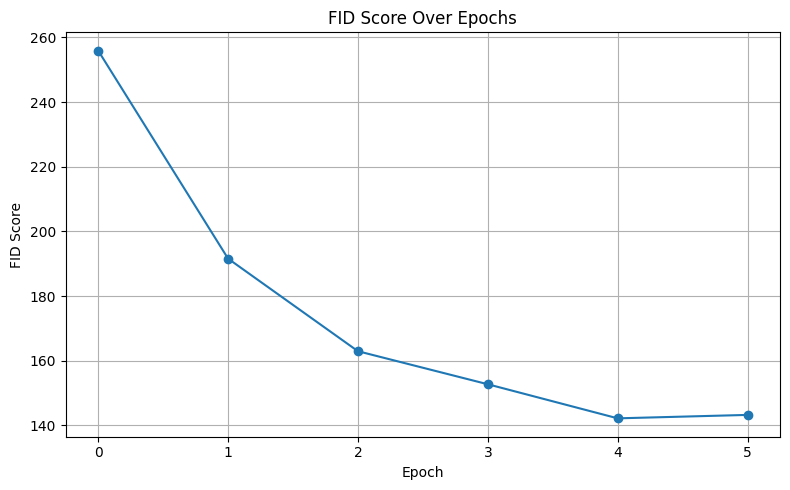

In [29]:
fid_epochs = list(range(6))  # [0, 1, 2, 3, 4]

plt.figure(figsize=(8, 5))
plt.plot(fid_epochs, FID_scores, marker='o', linestyle='-')
plt.title("FID Score Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# Evolution of Generator and Discriminator Losses over Training

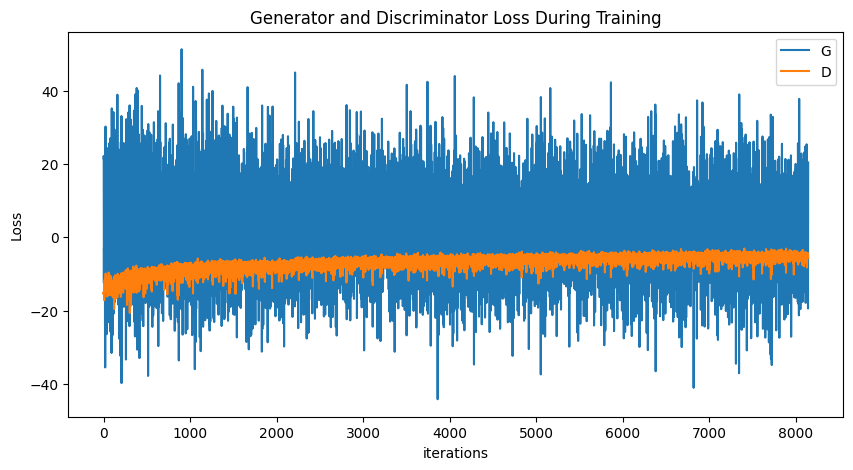

In [30]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Image Generator Evolution / Progression over the Epochs 

In [ ]:
if 'img_list' not in locals():
    img_list = []
    

In [ ]:
if img_list == []:
    checkpoint_dir = "checkpoints/"

# Ensure the directory exists
    if not os.path.exists(checkpoint_dir):
        raise FileNotFoundError(f"Checkpoint directory '{checkpoint_dir}' not found.")

# List all checkpoint files in the directory
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pkl')]

# Sort checkpoint files based on epochs (assuming filenames contain epoch numbers)
    checkpoint_files.sort(key=lambda x: int(x.split('_epoch_')[1].split('_')[0]))

# Fixed noise vector for generating consistent images
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)  # Adjust 'nz' and 'device' as per your setup

# Function to display images
    def show_generated_images(img_tensor, title=None):
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        if title:
            plt.title(title)
        plt.imshow(np.transpose(img_tensor.numpy(), (1, 2, 0)))
        plt.show()

# Iterate over each checkpoint file
    for checkpoint_file in checkpoint_files:
        checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)
    
    # Load the checkpoint
        with open(checkpoint_path, "rb") as f:
            checkpoint = pickle.load(f)
    
    # Load the generator's state_dict
        netG.load_state_dict(checkpoint['netG_state_dict'])
        netG.to(device)
        netG.eval()
    
    # Generate images using the fixed noise
        with torch.no_grad():
            fake_images = netG(fixed_noise).detach().cpu()
    
    # Create a grid of images
        img_grid = vutils.make_grid(fake_images, padding=2, normalize=True)
    
    # Display the image grid
        epoch = checkpoint['epoch']
        show_generated_images(img_grid, title=f"Generated Images at Epoch {epoch}")

    # Optionally, save the image grid to a file
    # vutils.save_image(img_grid, f"generated_images_epoch_{epoch}.png")

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# Real Images vs Fake Images

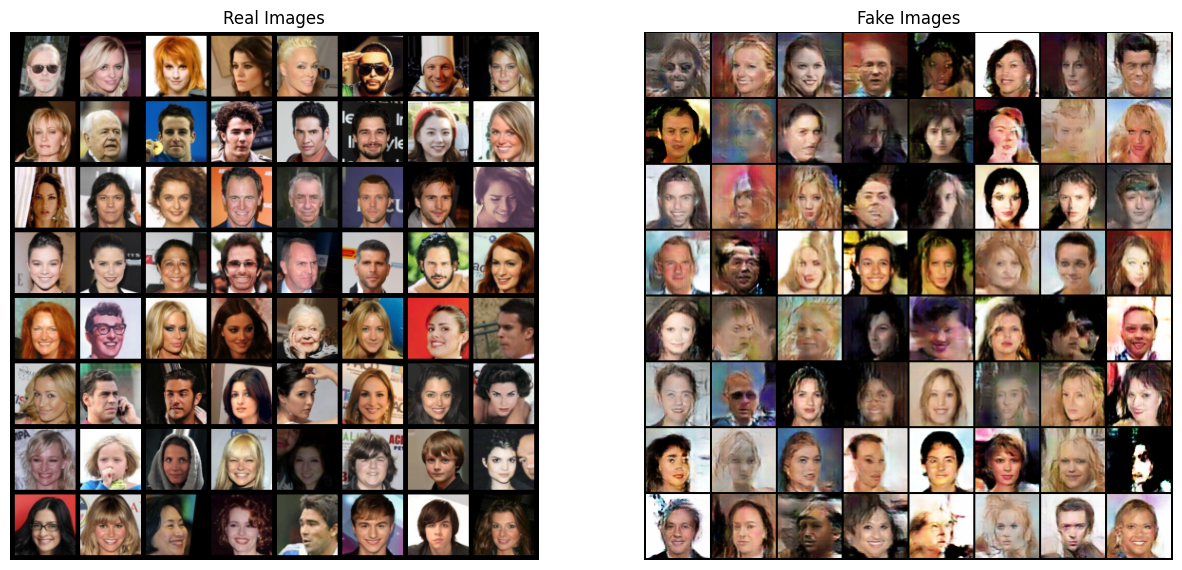

In [31]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()